### Imports

In [9]:
%matplotlib inline

import sys
from pathlib import Path
import numpy as np
from skimage import measure, morphology

parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))

from utils.img_io import read_image, write_image
from utils.viewer_utils import display_image_cursor, visualize_otsu_hist
from core.segmentation import otsu_threshold_itk_with_threshold, gaussian_smoothing_itk, crop_bbox

### Load Image

In [10]:
imgpath = Path("../../00_DATA/00_test/Sample1.ISQ")
outpath = imgpath.parent / "derived"
outpath.mkdir(exist_ok=True, parents=True)

img_itk, img_np = read_image(imgpath)

### Display original image

In [11]:
display_image_cursor(img_np, "Original Image")

interactive(children=(IntSlider(value=274, description='Slice:', max=547), Output()), _dom_classes=('widget-in…

### Segment image using Otsu's method

In [12]:
# sigma: 1 * voxel spacing (extract from itk image metadata)
seg_smooth = gaussian_smoothing_itk(img_itk)

seg_smooth_np = np.array(seg_smooth)
display_image_cursor(seg_smooth_np, "Smoothed Image")

seg_otsu, threshold = otsu_threshold_itk_with_threshold(seg_smooth)
display_image_cursor(seg_otsu, "Otsu Thresholding Segmentation")

interactive(children=(IntSlider(value=274, description='Slice:', max=547), Output()), _dom_classes=('widget-in…

interactive(children=(IntSlider(value=274, description='Slice:', max=547), Output()), _dom_classes=('widget-in…

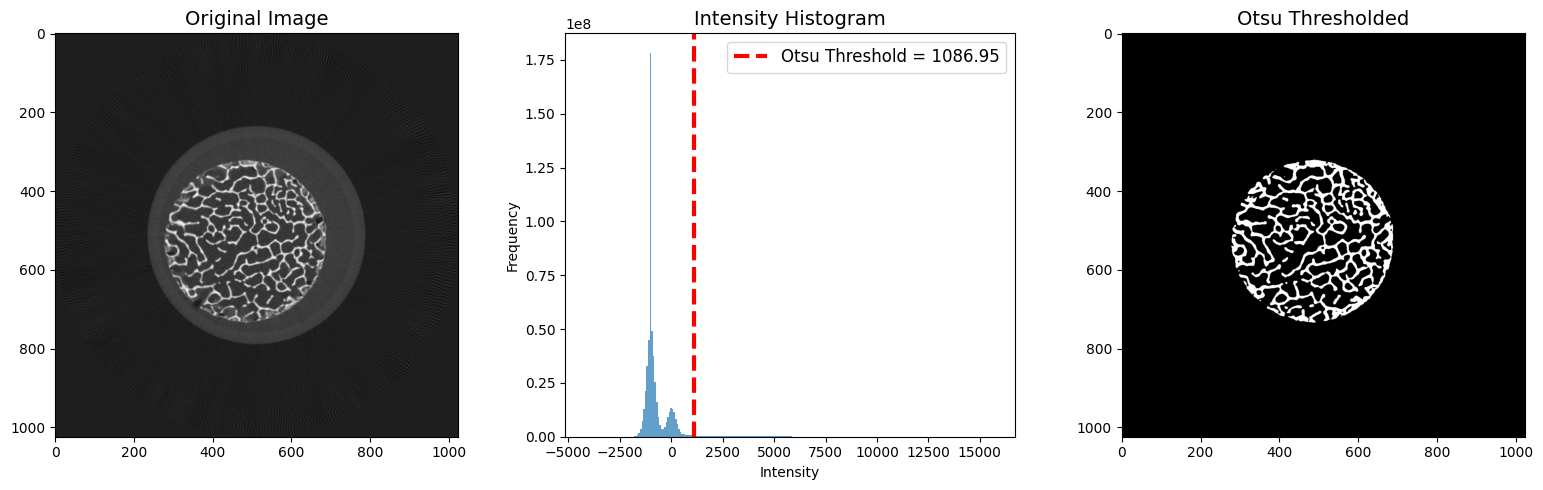

Otsu's threshold value: 1086.9487
Pixels above threshold: 22,676,754 (3.95%)
Pixels below threshold: 551,942,894 (96.05%)


In [13]:
visualize_otsu_hist(img_np, seg_otsu, threshold)

In [14]:
# crop image to minimum bounding box around segmented region + 20 voxels margin
cropped_seg_otsu, bbox = crop_bbox(seg_otsu, padding=10)

In [15]:
# Morphological close of binary image
morph_diam = 3  # voxels
cropped_seg_otsu_closed = morphology.closing(
    cropped_seg_otsu, morphology.ball(morph_diam)
)

# Detect largest isolated cluster of voxels
# Label the 3D image
[labels, n_labels] = measure.label(
    cropped_seg_otsu_closed, None, True, 1
)  # 1 connectivity hop
# Count the occurrences of each label
occurrences = np.bincount(labels.reshape(labels.size))
# Find the largest unconnected label
largest_label_id = occurrences[1:].argmax() + 1
# Create binary image of largest cluster, give it a meaningful name based on context
final_seg = labels == largest_label_id

# crop 10 slices in each direction to remove potential boundary artifacts in 0-axis
final_seg = final_seg[20:-20, :, :]

In [16]:
write_path = outpath / f"{imgpath.stem}_segmented.mha"
write_image(final_seg, write_path)
write_image(final_seg, write_path.with_suffix(".npy"))